In [15]:
import csky as cy
import numpy as np
import socket, getpass, sys, os
import config as cg
import trials
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

cy.plotting.mrichman_mpl

<function csky.plotting.mrichman_mpl(tex=True, sans=True, colors=array(['#1f77b4', '#d62728', '#2ca02c', '#ff7f0e', '#9467bd', '#8c564b',
       '#e377c2', '#7f7f7f'], dtype='<U7'))>

In [16]:
hostname = socket.gethostname()
username = getpass.getuser()
print('Running as User: {} on Hostname: {}'.format(username, hostname))
job_base = 'gp_fit_bf'
#job_base = 'systematics_full'
if 'condor00' in hostname or 'cobol' in hostname or 'gpu' in hostname:
    repo = cy.selections.Repository(
        local_root='/data/i3store/users/ssclafani/data/analyses'.format(username))
    template_repo = repo
    ana_dir = cy.utils.ensure_dir(
        '/data/i3store/users/{}/data/analyses'.format(username))
    base_dir = cy.utils.ensure_dir(
        '/data/i3store/users/{}/data/analyses/{}'.format(username, job_base))
    job_basedir = '/data/i3home/{}/submitter_logs'.format(username)
else:
    repo = cy.selections.Repository()
    template_repo = cy.selections.Repository(
        local_root='/data/ana/analyses/NuSources/2021_DNNCascade_analyses')
    ana_dir = cy.utils.ensure_dir('/data/user/{}/data/analyses'.format(username))
    base_dir = cy.utils.ensure_dir('/data/user/{}/data/analyses/{}'.format(username, job_base))
    ana_dir = '{}/ana'.format (base_dir)
    job_basedir = '/scratch/{}/'.format(username) 

# path at which source catalogs are located
catalog_dir = '/home/ssclafani/DNNCascade/catalogs/'

# Path to submit config file. This needs to be a relative path to $HOME
# Example content of this file:
#    eval `/cvmfs/icecube.opensciencegrid.org/py2-v3.0.1/setup.sh`
#    source  ~/path/to/venv/bin/activate
submit_cfg_file = 'DNNCascade/submitter_config'

Running as User: ssclafani on Hostname: cobalt07.icecube.wisc.edu


In [17]:
#pi0_cfg = cg.get_gp_conf('pi0', inj_gamma=2.7, cutoff_GeV = 1e3, base_dir=base_dir)

In [18]:
repo, ana_dir, base_dir, job_basedir = cg.repo, cg.ana_dir, cg.base_dir, cg.job_basedir
specs = cy.selections.DNNCascadeDataSpecs.DNNC_10yr
ana = cy.get_analysis(repo, 'version-001-p01', specs, dir = base_dir)

Setting up Analysis for:
DNNCascade_10yr
Setting up DNNCascade_10yr...
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.


In [19]:
temp = 'pi0'
inj_gamma = 2.7
fit_gamma = 2.7
inj_cutoff = 1e3
cpus = 8
def get_tr(temp, inj_gamma, inj_cutoff, fit_gamma, fit_cutoff):
    #print(inj_cutoff, fit_cutoff, inj_gamma, fit_gamma)
    gp_conf = cg.get_gp_conf(
        template_str=temp, inj_gamma=inj_gamma, fit_gamma=fit_gamma, inj_cutoff_GeV=inj_cutoff, fit_cutoff = fit_cutoff, base_dir=base_dir)
    tr = cy.get_trial_runner(gp_conf, ana=ana, mp_cpus=cpus)
    return tr

In [20]:
bkg_dict= cy.bk.get_all('/data/user/ssclafani/data/analyses/fit_cutoff/gp/trials/DNNC/pi0/fitgamma/', '*.npy', merge=np.concatenate, 
                  post_convert=(lambda x: cy.dists.Chi2TSD (cy.utils.Arrays (x))))

/data/user/ssclafani/data/analyses/fit_cutoff/gp/trials/DNNC/pi0/fitgamma/2.500/fitcutoff/10000/bkg/trials_0000100__seed_0000000000.npy ...
/data/user/ssclafani/data/analyses/fit_cutoff/gp/trials/DNNC/pi0/fitgamma/2.500/fitcutoff/10000/bkg/trials_0025000__seed_0000000000.npy ...
/data/user/ssclafani/data/analyses/fit_cutoff/gp/trials/DNNC/pi0/fitgamma/2.500/fitcutoff/1000000/bkg/trials_0000100__seed_0000000000.npy ...
/data/user/ssclafani/data/analyses/fit_cutoff/gp/trials/DNNC/pi0/fitgamma/2.500/fitcutoff/1000000/bkg/trials_0025000__seed_0000000000.npy ...
/data/user/ssclafani/data/analyses/fit_cutoff/gp/trials/DNNC/pi0/fitgamma/2.500/fitcutoff/123285/bkg/trials_0000100__seed_0000000000.npy ...
/data/user/ssclafani/data/analyses/fit_cutoff/gp/trials/DNNC/pi0/fitgamma/2.500/fitcutoff/123285/bkg/trials_0025000__seed_0000000000.npy ...
/data/user/ssclafani/data/analyses/fit_cutoff/gp/trials/DNNC/pi0/fitgamma/2.500/fitcutoff/15199/bkg/trials_0000100__seed_0000000000.npy ...
/data/user/ssc

In [21]:
fit_gammas = np.arange(2.5,3.51,.1)
fit_cutoffs = np.logspace(4,6,12)

def get_mtr(ana, temp, inj_gamma, inj_cutoff, fit_gammas, fit_cutoffs):
    trs = []
    bgs = []
    for fit_gamma in sorted(fit_gammas):
        for fit_cutoff in sorted(fit_cutoffs):
            trs.append(get_tr(temp, inj_gamma, inj_cutoff, fit_gamma, fit_cutoff))
            bgs.append(cy.bk.get_best(bkg_dict, fit_gamma, 'fitcutoff', fit_cutoff, 'bkg'))

    return trs, bgs

In [22]:
trs, bgs = get_mtr(ana, 'pi0', 2.5,np.inf, fit_gammas, fit_cutoffs)

	Setting Gamma for pi0 to: 2.500!
<- /data/user/ssclafani/data/analyses/fit_cutoff/templates/pi0/gamma/2.500/DNNCascade_10yr.template.npy    
Restore successful.
	Setting Gamma for pi0 to: 2.500!
<- /data/user/ssclafani/data/analyses/fit_cutoff/templates/pi0/gamma/2.500/DNNCascade_10yr.template.npy    
Restore successful.
	Setting Gamma for pi0 to: 2.500!
<- /data/user/ssclafani/data/analyses/fit_cutoff/templates/pi0/gamma/2.500/DNNCascade_10yr.template.npy    
Restore successful.
	Setting Gamma for pi0 to: 2.500!
<- /data/user/ssclafani/data/analyses/fit_cutoff/templates/pi0/gamma/2.500/DNNCascade_10yr.template.npy    
Restore successful.
	Setting Gamma for pi0 to: 2.500!
<- /data/user/ssclafani/data/analyses/fit_cutoff/templates/pi0/gamma/2.500/DNNCascade_10yr.template.npy    
Restore successful.
	Setting Gamma for pi0 to: 2.500!
<- /data/user/ssclafani/data/analyses/fit_cutoff/templates/pi0/gamma/2.500/DNNCascade_10yr.template.npy    
Restore successful.
	Setting Gamma for pi0 to: 2

In [23]:
idx_inj = 42

In [24]:
mtr =   cy.trial.MultiTrialRunner(
        # the Analysis
        ana,
        # bg+sig injection trial runner (produces trials)
        tr_inj=trs[idx_inj],
        # llh test trial runners (perform fits given trials)
        trs=trs,
        # background distrubutions
        bgs=bgs,
        # use multiprocessing
        mp_cpus=8,
        
    )



In [25]:
#%time bg = mtr.get_many_fits(0, 100)
nsig = 750
%time sig = mtr.get_many_fits(100, nsig)

Performing 100 trials with n_sig = 750.000 using 8 cores:
        100/100 trials complete.   
CPU times: user 430 ms, sys: 3.19 s, total: 3.62 s
Wall time: 2min 47s


In [26]:
df = sig.as_dataframe
tss = df.filter(like='ts').median().values
reshape_ts = np.reshape(tss, (11,12))
idx = np.argmax(tss)
tssmax = (np.unravel_index(idx, shape=reshape_ts.shape))
max_g = fit_gammas[tssmax[0]]
max_c = fit_cutoffs[tssmax[1]]

injtr = (np.unravel_index(idx_inj, shape=reshape_ts.shape))
inj_g = fit_gammas[injtr[0]]
inj_c = fit_cutoffs[injtr[1]]

/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  del sys.path[0]


Text(0, 0.5, 'log E$_{C}$ ')

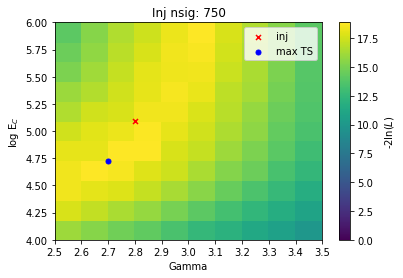

In [27]:

df = sig.as_dataframe

fig, ax = plt.subplots()
mlog10ps = df.filter(like='mlog10p').median().values
tss = df.filter(like='ts').median().values

nss = df.filter(like='ns').median().values  
reshape_ts = np.reshape(tss, (11,12))

gamma, cutoff = np.meshgrid( fit_gammas, np.log10(fit_cutoffs),)

plt.pcolormesh(gamma, cutoff, reshape_ts.T,
           cmap='viridis',vmin=0)


plt.colorbar(label='-2ln($L$)')
plt.title('Inj nsig: {}'.format(nsig))
plt.xticks(fit_gammas)
plt.scatter(inj_g, np.log10(inj_c), marker='x', s=25, c='r', label='inj')
plt.scatter(max_g, np.log10(max_c), marker='o', s=25, c='blue', label='max TS')
plt.xlabel('Gamma')
plt.legend()
plt.ylabel('log E$_{C}$ ')


/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  app.launch_new_instance()


Text(0, 0.5, 'log E$_{C}$ ')

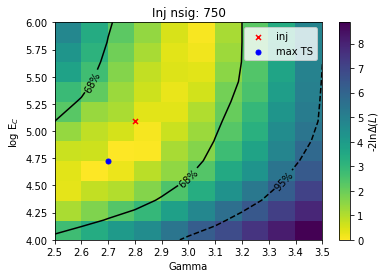

In [28]:

df = sig.as_dataframe

fig, ax = plt.subplots()
mlog10ps = df.filter(like='mlog10p').median().values
tss = df.filter(like='ts').median().values
delta_tss = -(tss - max(tss))
nss = df.filter(like='ns').median().values  
reshape_ts = np.reshape(delta_tss, (11,12))

gamma, cutoff = np.meshgrid( fit_gammas, np.log10(fit_cutoffs),)
contour_fracs = [0.68, .95]
dLLHs = stats.chi2.ppf (contour_fracs, 2)
contour_labels = {dLLH: r'{:.0f}$\%$'.format (100*frac) for (dLLH, frac) in zip (dLLHs, contour_fracs)}

plt.pcolormesh(fit_gammas, np.log10(fit_cutoffs), reshape_ts.T,
           cmap='viridis_r',vmin=0)
plt.colorbar(label='-2ln$\Delta$($L$)')

cont = plt.contour(fit_gammas, np.log10(fit_cutoffs), reshape_ts.T, dLLHs, colors='k', linestyles=['solid', 'dashed'])
ax.clabel (cont, inline=True, fmt=contour_labels, fontsize=10, inline_spacing=1)

plt.title('Inj nsig: {}'.format(nsig))
plt.xticks(fit_gammas)
plt.scatter(inj_g, np.log10(inj_c), marker='x', s=25, c='r', label='inj')
plt.scatter(max_g, np.log10(max_c), marker='o', s=25, c='blue', label='max TS')
plt.xlabel('Gamma')
plt.legend()
plt.ylabel('log E$_{C}$ ')